In [1]:
#Cell 1: Read ME!
"""
CELL 1: Read Me

Cells 2-4 are initilization of simulator

Cell 5 initializes a full-control simulator named "sim"

Cell 6 initializes helper functions to scale particle & quiver size

Cell 7 generates visualization of first N steps for sim, also where you set frame & capture rate

Cell 8 runs a pure physics simulation of first N steps for sim, also optionally generates 1st & last frames

Cell 9 generates any visualization created in previous 2 steps

Cell 10 is 2 helper functions to help with MB calculations

Cell 11 is a mega plotting function that graphs actual velocity distribution x expected, along with quantifiable error metrics (L1 is most helpful imo)

Cell 12 creates a new simulator instance and runs N steps, taking a snapshot (saves particle velocities) at user-defined intervals

Cell 13 visualizes convergence to MB from constant velocity

Cell 14 visualizes adherence to MB of a particular snapshot / final state

Cell 15 initializes real CPU runtime of Simulator class for 50 steps x theoretical GPU runtime

Cell 16 runs & plots function from cell 15

Useful Notes:

- Inside cell 5, simulation settings can be modified for visualization.
    There are sample combinations provided inside quotations that will not crash the program

- Inside cell 7 there are visualization settings. It is possible to increase framerate picture quality, and # of frames captured, but not recommended to do so.
    Oftentimes, the reason the simulation crashes is due to too many frames with too many pixels overloading the storage
    It is a good idea to not exceed 1000 steps of 300 particles for 6 frames captured per second displayed at 45 frames per second, with an 8 inch length x 80 pixel clarity. 
    
- Inside cell 11 there is a total_bins variable that can be modified to plot the simulated particles using a user_defined amount of bins.

- The variables at the top of cell 12 can be modified to create more intensive pure-physics simulations. There is no worry about overloading RAM here, as the particles & calculations themselves do not take up much storage.
    The main limitation is how long the user is willing to sit at their desk while the simulation runs
    A simulation of 100,000 particles for 10,000 steps will take ~ ___ seconds to run on a Macbook Air M4


- To view the difference in runtime between Numba compilation & running in pure python: 
    After running each cell in the notebook, comment out the @njit decorators above each function inside Cell 3
    Then, run cell 3 to update changes
    Then, run cell 16.
    Warning: before doing this, I recommend changing the up_to varible inside cell 16 to something lesser, like 8, and adjusting + observing runtime changes from there
    (You should see ~100x slowdown in the early stages)
"""
print("read me")

read me


In [2]:
#Cell 2
!pip install imageio
!pip install numba
#imports & configuration
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import time
import os
import gc
import contextlib
from numba import njit, float64, int32
from IPython.display import Image, display
from scipy.stats import maxwell

#Set plot style
plt.style.use('ggplot')
print("Imports successful")
print(os.getcwd())

Imports successful
/home/jovyan/Final_Project


In [3]:
#Cell 3
#Physics kernels used in simulation class
#These use numba JIT compiler (njit decorator) to reduce runtime
@njit(cache=True)
def pbc_dist(r1, r2, box_L):
    """
    Minimum image convention: calculates shortest distance vector (dx, dy) and squared distance (r2)
    under periodic boundary conditions
    """
    dx = r1[0] - r2[0]
    dy = r1[1] - r2[1]

    #Wrapping logic for minimum image convention:
    #Wrap dx/dy if they exceed L/2 (particles are closer if they wrap around the boundary)
    if dx > box_L * 0.5: 
        dx -= box_L
    elif dx < -box_L * 0.5: 
        dx += box_L
    
    if dy > box_L * 0.5: 
        dy -= box_L
    elif dy < -box_L * 0.5: 
        dy += box_L

    #Return r2 (memory trick)
        #LJ potential depends on r^-6 and r^-12 which can be calculated directly from r^2 without a square root
    r2 = dx*dx + dy*dy
    return dx, dy, r2

@njit(cache=True)
def compute_forces_cell_list(pos, box_L, rcut, epsilon, sigma):
    N = pos.shape[0]
    forces = np.zeros((N, 2), dtype=np.float64)
    pot_energy = 0.0

    rcut2 = rcut * rcut
    cell_size = rcut
    nx = int(box_L / cell_size)
    if nx < 1:
        nx = 1
    ny = nx
    
    cell_heads = -1 * np.ones(nx * ny, dtype=np.int32)
    linked_list = -1 * np.ones(N, dtype=np.int32)

    #Assign each particle to a cell
    for i in range(N):
        cx = int(pos[i, 0] / cell_size)
        cy = int(pos[i, 1] / cell_size)

        if cx < 0:
            cx = 0
        elif cx >= nx:
            cx = nx - 1
        if cy < 0:
            cy = 0
        elif cy >= ny:
            cy = ny - 1

        c_index = cx + cy * nx
        linked_list[i] = cell_heads[c_index]
        cell_heads[c_index] = i

    #Lennard jones constants
    sig2 = sigma * sigma
    sig6 = sig2 * sig2 * sig2
    sig12 = sig6 * sig6
    force_pre = 24.0 * epsilon
    pe_pre = 4.0 * epsilon

    #Loop over cells and neighbors
    for cy in range(ny):
        for cx in range(nx):

            c = cx + cy * nx
            i = cell_heads[c]

            #Loop over particles in this cell
            while i != -1:

                #Loop over neighboring cells (3×3 region)
                for off_y in (-1, 0, 1):
                    for off_x in (-1, 0, 1):

                        ncx = cx + off_x
                        ncy = cy + off_y

                        #Periodic wrap
                        if ncx < 0:
                            ncx += nx
                        elif ncx >= nx:
                            ncx -= nx
                        if ncy < 0:
                            ncy += ny
                        elif ncy >= ny:
                            ncy -= ny

                        nc = ncx + ncy * nx
                        j = cell_heads[nc]

                        #Loop over particles in neighbor cell
                        while j != -1:

                            if j > i:   #Avoid double counting
                                dx_r, dy_r, r2 = pbc_dist(pos[i], pos[j], box_L)

                                if r2 < rcut2 and r2 > 1e-12:
                                    r2_inv = 1.0 / r2
                                    r6_inv = r2_inv * r2_inv * r2_inv
                                    term6 = sig6 * r6_inv
                                    term12 = term6 * term6

                                    f_scalar = (force_pre * r2_inv) * (2.0 * term12 - term6)
                                    fx = f_scalar * dx_r
                                    fy = f_scalar * dy_r

                                    forces[i, 0] += fx
                                    forces[i, 1] += fy
                                    forces[j, 0] -= fx
                                    forces[j, 1] -= fy

                                    pot_energy += pe_pre * (term12 - term6)

                            j = linked_list[j]

                i = linked_list[i]

    return forces, pot_energy
print("Kernels initialized")

Kernels initialized


In [4]:
#Cell 4
#Simulation class
class Simulator:
    def __init__(self, N=200, L=20.0, dt=0.002, rcut=2.5, epsilon=1.0, sigma=1.0, mass=1.0, init_mode="random", speed0=1.0, target_density=0.8):
        self.N = N
        self.dt = dt
        self.rcut = rcut
        self.epsilon = epsilon
        self.sigma = sigma
        self.mass = mass
        #natural time unit calculation
        tau = self.sigma * np.sqrt(self.mass / self.epsilon)
        print(f"tau = {tau}")
        dt = 0.002 * tau
        print(f"dt = {dt}")

        """
        #Dont uncomment this, its js an example
        simulation for argon:
        sim_Argon = Simulator(n=2000, L=NONE, epsilon = 1.65e-21, sigma = 3.4e-10, mass = 6.63e-26)
        """

        #Density: rho = N / L^2. A safe density for 2D LJ liquid is ~0.8
        self.target_density = target_density
        print(f"density = {self.target_density}")


        #Special calculation for L to account for massive particle counts that user lets simulation determine L for
        min_L = np.sqrt(N / self.target_density)
        if L is None:
            self.L = min_L
        else:
            #If there is a provided L, make sure it isn't too small (can lead to particles spawning on each other which breaks the simulation)
            if L < min_L:
                print(f"L={L} is too small for N={N}. Using L={min_L:.2f} instead")
                self.L = min_L
            else:
                self.L = L
        
        #State Arrays
        self.pos = np.zeros((N, 2))
        self.vel = np.zeros((N, 2))
        self.forces = np.zeros((N, 2))
        
        #Cell list parameters
        self.cell_size = rcut
        self.nx = int(self.L / self.cell_size)
        self.ny = int(self.L / self.cell_size)
        
        self.init_positions()
        #self.init_velocities() < old code, new code inserted right below
        #special velocity initialization to demonstrate MB convergence
        if init_mode == "random":
            #Normal mode, this produces a MB-like initial distribution
            self.init_velocities()
        elif init_mode == "const_speed":
            #to achieve random direction & constant speed: speed0 * randomized direction
            angles = 2*np.pi*np.random.rand(N)
            self.vel = np.column_stack([speed0*np.cos(angles),
                                        speed0*np.sin(angles)])
        else:
            raise ValueError(f"Incorrect init_mode: {init_mode}")

        #Record initial position & velocities after building cell list for reproducibility
        self.forces, self.pe = compute_forces_cell_list(self.pos, self.L, self.rcut, self.epsilon, self.sigma)
        self.initial_pos = self.pos.copy()
        self.initial_vel = self.vel.copy()

    
    def init_positions(self):
        """Initialize positions on a lattice-type grid to prevent overlaps"""
        grid_side = int(np.ceil(np.sqrt(self.N)))
        spacing = self.L / grid_side
        idx = 0
        for i in range(grid_side):
            for j in range(grid_side):
                if idx < self.N:
                    self.pos[idx] = [i * spacing + spacing/2, j * spacing + spacing/2]
                    idx += 1

    def init_velocities(self, temp=1.0):
        """Initialize random velocities and remove COM drift"""
        self.vel = np.random.normal(0, np.sqrt(temp), (self.N, 2))
        #Center of Mass Correction
        v_cm = np.mean(self.vel, axis=0)
        self.vel -= v_cm

    
    def step(self):
        """
        Velocity verlet integration step following this procedure:
        Update v (half step velocity update)
        Update r (full step position update)
        Compute F (r_new; recomputing forces @ new positions)
        Update v (finish half step; complete velocity update)
        """
        #Half-step velocity update
        self.vel += 0.5 * self.dt * self.forces / self.mass
        
        #Position update using half-step velocity
        self.pos += self.dt * self.vel
        self.pos = self.pos % self.L #Periodic Boundaries
        
        #Recompute forces at new positions (new accelerations & PE)
        self.forces, self.pe = compute_forces_cell_list(self.pos, self.L, self.rcut, self.epsilon, self.sigma)
        
        #Second half-step velocity update
        self.vel += 0.5 * self.dt * self.forces / self.mass
        
        #Calculate KE from updated forces
        self.ke = 0.5 * self.mass * np.sum(self.vel**2)

print("Simulator class initialized")

Simulator class initialized


In [5]:
#Cell 5
#Simulation Settings:
PARTICLES = 300 #Self-explanatory; can be significantly increased if GIF generation is turned off
STEPS = 1000 #Total amt of steps
GENERATE_GIF, SAVE_PNG = True, False #Set both to False for a pure physics run, better for simulating large datasets for many steps

#Other settings, don't usually need to change
INIT_MODE ="random" #change to const_speed to demonstrate MB convergence
SPEED0=3.0 #speed for particles to initialize with; calculated in ____ units, only matters when init_mode is not random
L_val = 20.0 # _______(explanation of L)
RCUT=2.5
TIMESTEP=0.001
EPSILON=1.0
SIGMA=1.0
MASS=1.0
DENSITY = 0.8

"""
Use these settings to touch the memory limit of the simulator:
STEPS = 1000      
PARTICLES = 1000
#GIF settings:
FRAMES_PER = 30
SAVE_EVERY = 6
inches = 8
pixels = 80
GENERATE_GIF, SAVE_PNG = True, False
"""
"""
Use these settings to demonstrate the lennard-jones curve:
STEPS = 1000      
PARTICLES = 30
FRAMES_PER = 30
SAVE_EVERY = 3
inches = 7
pixels = 60
GENERATE_GIF, SAVE_PNG = True, False
"""

#Initializes simulator using a default value of 20.0 for L if L is 300 or less, anything above uses the simulation class's automatic scaling
#A safe L is approx sqrt(N / 0.8). setting L_val equal to None will make the simulator autocalculate a safe L value
if PARTICLES > 300:
    L_val = None
sim = Simulator(N=PARTICLES, L=L_val, dt=TIMESTEP, rcut=RCUT, epsilon=EPSILON, sigma=SIGMA, mass = MASS, init_mode=INIT_MODE, speed0=SPEED0, target_density = DENSITY,)
print(f"Simulation = sim initialized with N={sim.N} particles; using L={sim.L}")

tau = 1.0
dt = 0.002
density = 0.8
Simulation = sim initialized with N=300 particles; using L=20.0


In [6]:
#Cell 6
#Cleans memory to preserve space for repeated simulation
plt.close('all')
gc.collect()

#particle & quiver helper functions to dynamically scale particle & arrow size with L
def compute_particle_size(L, base_size=80.0, L_ref=20.0):
    """
    Scales scatter marker area inversely with L^2 so particle visual size remains proportional even when the simulation box changes
    """
    return base_size * (L_ref / L)**2
    
def compute_quiver_scale(L, base_scale=4.0, L_ref=20.0):
    """
    Scales quiver arrow lengths, matplotlib quiver uses arrow_length ∝ 1/scale so to keep arrows proportional as L increases:
    new_scale = base_scale * (L / L_ref)
    """
    return base_scale * (L / L_ref)
    
def setup_plot_axes(ax, L, rcut):
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect("equal")
    
    cell_size = rcut
    nx = int(L / cell_size)
    ny = int(L / cell_size)
    for i in range(nx + 1):
        ax.axvline(i * cell_size, color="gray", linewidth=0.4, alpha=0.25, zorder=0)
    for j in range(ny + 1):
        ax.axhline(j * cell_size, color="gray", linewidth=0.4, alpha=0.25, zorder=0)

print("Visual element helpers initialized")

Visual element helpers initialized


In [7]:
#Cell 7
#Visualization settings:
FRAMES_PER = 45 #Frames displayed per second
SAVE_EVERY = 6 #Saves every nth frame
inches = 8
pixels = 80

#Execution logic:
if GENERATE_GIF:
    gif_path = 'trajectory_visualization.gif'
    print(f"GIF generation turned on\nFrames will be saved to path {gif_path}")
    
    #Creates the figure
    fig, ax = plt.subplots(figsize=(inches, inches), dpi=pixels)
    setup_plot_axes(ax, sim.L, sim.rcut)

    #Initializes visual elements
    speed = np.linalg.norm(sim.vel, axis=1)
    scat = ax.scatter(sim.pos[:,0], sim.pos[:,1], c=speed, cmap='plasma', s=compute_particle_size(sim.L), zorder=2, edgecolors='black', linewidth=0.5, vmin=0, vmax=2.5)
    quiv = ax.quiver(sim.pos[:,0], sim.pos[:,1], sim.vel[:,0], sim.vel[:,1], color='black', alpha=0.6, angles='xy', scale_units='xy', scale=compute_quiver_scale(sim.L), width=0.003, zorder=3)
    title_text = ax.text(0.5, 1.01, "", transform=ax.transAxes, ha='center', fontweight='bold')
    print("Initialized visual elements")
    
    #Run loop with ImageIO writer; uses streaming to preserve RAM    
    with imageio.get_writer(gif_path, mode='I', fps=FRAMES_PER, loop=0) as writer:
        for s in range(STEPS):
            sim.step()
            
            if s % SAVE_EVERY == 0:
                #Update visual data
                speed = np.linalg.norm(sim.vel, axis=1)
                scat.set_offsets(sim.pos)
                scat.set_array(speed)
                scat.set_sizes(np.full(sim.N, compute_particle_size(sim.L)))
                quiv.set_offsets(sim.pos)
                quiv.set_UVC(sim.vel[:,0], sim.vel[:,1])
                quiv.scale = compute_quiver_scale(sim.L)
                title_text.set_text(f"Step {s} | N={sim.N}")

                #Render to buffer
                buf = io.BytesIO()
                fig.savefig(buf, format='png')
                buf.seek(0)
                writer.append_data(imageio.imread(buf))
                buf.close()
                
            if s * 10 % STEPS == 0:
                print(f"Step {s}/{STEPS} completed")

    plt.close(fig)
    print(f"Step {STEPS}/{STEPS} completed")
    print("GIF complete")

else:
    print("GIF generation turned off. Try running next cell.")

GIF generation turned on
Frames will be saved to path trajectory_visualization.gif
Initialized visual elements
Step 0/1000 completed
Step 100/1000 completed
Step 200/1000 completed
Step 300/1000 completed
Step 400/1000 completed
Step 500/1000 completed
Step 600/1000 completed
Step 700/1000 completed
Step 800/1000 completed
Step 900/1000 completed
Step 1000/1000 completed
GIF complete


In [8]:
#Cell 8
#pure computation
if not GENERATE_GIF:
    if SAVE_PNG:
        png_path_initial = 'initial_state.png'
        print(f"Saving initial state snapshot to {png_path_initial}")
        fig, ax = plt.subplots(figsize=(inches, inches), dpi=pixels)
        setup_plot_axes(ax, sim.L, sim.rcut)
        speed = np.linalg.norm(sim.vel, axis=1)
        #Particles
        ax.scatter(sim.pos[:,0], sim.pos[:,1], c=speed, cmap='plasma', 
                   s=compute_particle_size(sim.L), zorder=2, edgecolors='black', linewidth=0.5, vmin=0, vmax=2.5)
        #Velocity Arrows
        ax.quiver(sim.pos[:,0], sim.pos[:,1], sim.vel[:,0], sim.vel[:,1],
                  color='black', alpha=0.6, angles='xy', scale_units='xy', 
                  scale=compute_quiver_scale(sim.L), width=0.003, zorder=3)      
        ax.set_title(f"Initial State | N={sim.N}")
        fig.savefig(png_path_initial)
        plt.close(fig)

    print("Running pure physics simulation")
    start_time = time.time()
    for s in range(STEPS):
        sim.step()
        #Prints progress 10 times across the entire simulation
        if s * 10 % STEPS == 0:
            print(f"Step {s}/{STEPS} completed")

            
    elapsed = time.time() - start_time
    print(f"Step {STEPS}/{STEPS} completed")
    print(f"Simulation finished in {elapsed:.4f} seconds")
    print(f"Performance: {(STEPS/elapsed):.2f} steps per second")

    #Plot final state if requested
    if SAVE_PNG:
        png_path_final = 'final_state.png'
        print(f"Saving final state snapshot to {png_path_final}")
        fig, ax = plt.subplots(figsize=(inches, inches), dpi=pixels)
        setup_plot_axes(ax, sim.L, sim.rcut)
        speed = np.linalg.norm(sim.vel, axis=1)
        #Particles
        ax.scatter(sim.pos[:,0], sim.pos[:,1], c=speed, cmap='plasma', 
                   s=compute_particle_size(sim.L), zorder=2, edgecolors='black', linewidth=0.5, vmin=0, vmax=2.5)
        #Velocity Arrows
        ax.quiver(sim.pos[:,0], sim.pos[:,1], sim.vel[:,0], sim.vel[:,1],
                  color='black', alpha=0.6, angles='xy', scale_units='xy', 
                  scale=compute_quiver_scale(sim.L), width=0.003, zorder=3)      
        ax.set_title(f"Final State (Step {STEPS}) | N={sim.N}")
        fig.savefig(png_path_final)
        plt.close(fig)
else:
    print("GIF generation enabled. Please run next cell for step visualization")

GIF generation enabled. Please run next cell for step visualization


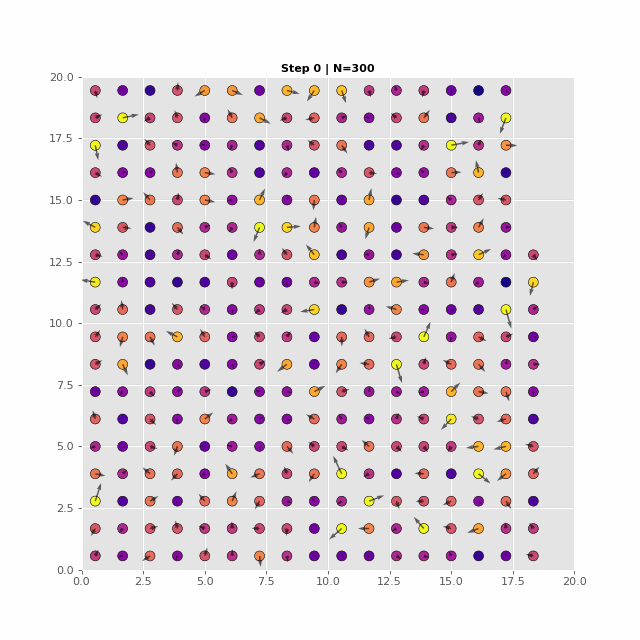

In [9]:
#Cell 9
#displays the infinitely looping gif, or the static image of final particle trajectory
if GENERATE_GIF:
    from IPython.display import Image, display
    with open(gif_path, 'rb') as f:
        display(Image(data=f.read(), format='gif'))
if SAVE_PNG:
    from IPython.display import Image, display
    with open(png_path_initial, 'rb') as f:
        display(Image(data=f.read(), format='png'))
    with open(png_path_final, 'rb') as f:
        display(Image(data=f.read(), format='png'))
if not GENERATE_GIF and not SAVE_PNG:
    print("Nothing to display! Run the next cells to demonstrate convergence tests.")

In [10]:
#Cell 10
#more helper functions
def compute_temperature(v):
    """
    Computes instantaneous temperature from velocity matrix.
    Formula: T = 0.5 * <v^2> (assuming m=1, k_B=1)
    """
    return 0.5 * np.mean(np.sum(v**2, axis=1))

def mb_pdf_2d(v, T, m=1.0):
    """
    Theoretical Maxwell-Boltzmann Probability Density Function for 2D.
    f(v) = (m*v / T) * exp(-m*v^2 / 2T)
    """
    return (m * v / T) * np.exp(-m * v**2 / (2*T))

In [11]:
#Cell 11
total_bins = 25

def analyze_distribution(velocities, step_label, ax=None, detailed_stats=False):
    """
    Plots the velocity histogram against the theoretical MB curve.
    If detailed_stats=True, computes and prints L1 and Chi-sq error metrics.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    #Calculate temp & speeds
    speeds = np.linalg.norm(velocities, axis=1)
    T_meas = compute_temperature(velocities)
    
    #Plot histogram
    count, bins, _ = ax.hist(speeds, bins=total_bins, density=True, 
                             alpha=0.6, color='dodgerblue', edgecolor='black', label='Sim1 Data')
    
    #Theoretical MB curve
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    v_smooth = np.linspace(0, bins.max(), 200)
    pdf_smooth = mb_pdf_2d(v_smooth, T_meas)
    ax.plot(v_smooth, pdf_smooth, 'r--', linewidth=2, label=f'MB Expected (T={T_meas:.2f})')
    
    #Formatting
    ax.set_title(f"Velocity Distribution @ Step {step_label}")
    ax.set_xlabel("Speed |v|")
    ax.set_ylabel("PDF")
    ax.grid(True, alpha=0.3)
    if detailed_stats:
        ax.legend()

    #Error metrics quantified
    if detailed_stats:
        pdf_theory_bins = mb_pdf_2d(bin_centers, T_meas)
        dv = bins[1] - bins[0]
        abs_err = np.abs(count - pdf_theory_bins)
        L1_err = np.sum(abs_err * dv)
        chi_sq = np.sum((abs_err**2) / (pdf_theory_bins + 1e-12))
        
        print(f"Verification step {step_label}")
        print(f"Measured temp: {T_meas:.3f}")
        print(f"L1 error: {L1_err:.4f}") 
        print(f"Chi-square: {chi_sq:.4f}")
        print(f"Max bin error: {np.max(abs_err):.4f}")

In [12]:
#Cell 12

#Settings
PARTICLES1 = 100000
speed0 = 3.0
snapshot_steps = [0, 1, 5, 10, 25, 50, 75, 100, 10000] # Checkpoints
STEPS = max(snapshot_steps)

sim1 = Simulator(N=PARTICLES1, L=None, init_mode="const_speed", speed0=speed0)

#sim1 = sim
print(f"Initialized N={sim1.N} particles with constant speed |v|={SPEED0}")

#Storage
snapshots = {} #Stores {step: velocity_array}
sim1.step()
snapshots[0] = sim1.vel.copy()

#Run Simulation Loop
print(f"Simulating {STEPS} steps")
for s in range(1, STEPS + 1):
    sim1.step()
    if s in snapshot_steps:
        snapshots[s] = sim1.vel.copy()
        print(f"Recorded snapshot at step {s}")

print("Simulation complete.\n")

tau = 1.0
dt = 0.002
density = 0.8
Initialized N=100000 particles with constant speed |v|=3.0
Simulating 10000 steps
Recorded snapshot at step 1
Recorded snapshot at step 5
Recorded snapshot at step 10
Recorded snapshot at step 25
Recorded snapshot at step 50
Recorded snapshot at step 75
Recorded snapshot at step 100
Recorded snapshot at step 10000
Simulation complete.



Visualizing convergence


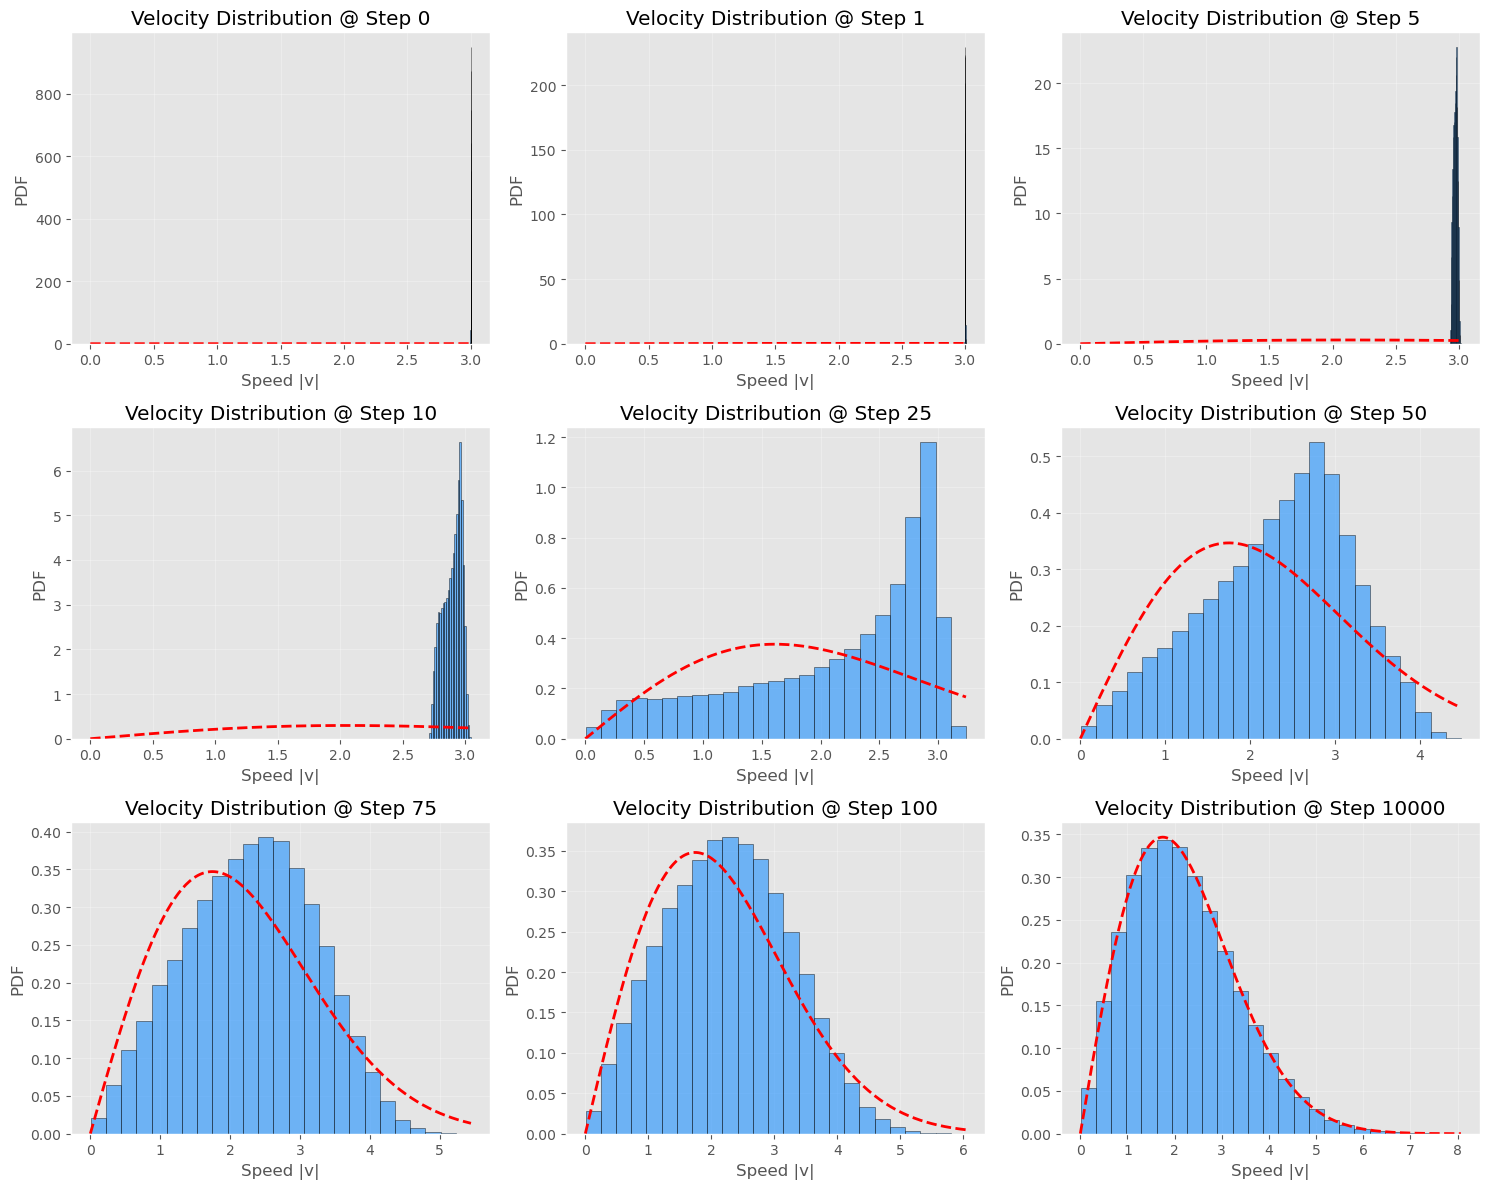

In [13]:
#Cell 13
print("Visualizing convergence")
cols = 3
rows = int(np.ceil(len(snapshot_steps) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for idx, step in enumerate(snapshot_steps):
    if step in snapshots:
        analyze_distribution(snapshots[step], step, ax=axes[idx], detailed_stats=False)
    else:
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

Quantifying MB adherence of constant-initialized MB diagram
Verification step 10000
Measured temp: 3.060
L1 error: 0.0085
Chi-square: 0.0004
Max bin error: 0.0031


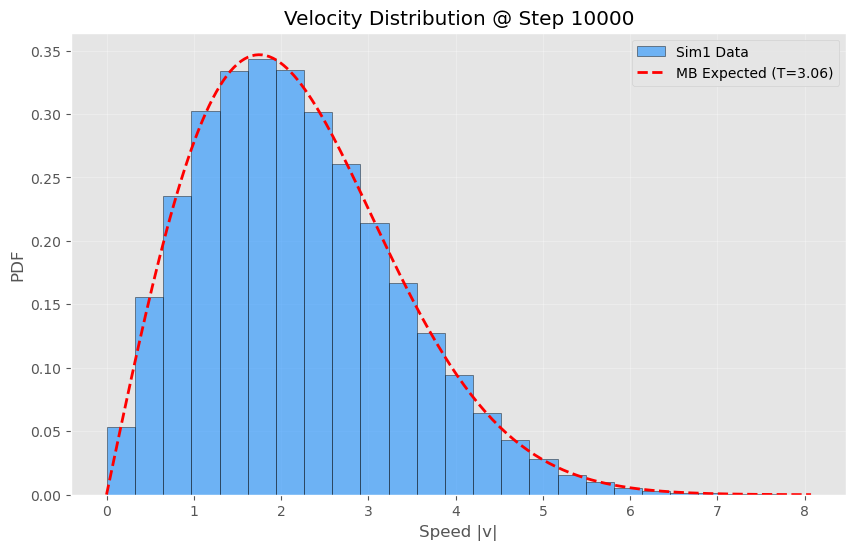

In [14]:
#Cell 14
#Detailed physics check:
print("Quantifying MB adherence of constant-initialized MB diagram")
plt.figure(figsize=(10,6))
analyze_distribution(snapshots[STEPS], STEPS, ax=plt.gca(), detailed_stats=True)
plt.show()

In [15]:
def benchmark(simulator_cls, max_pow=18):
    #Parameters:
    #Stops around 2^15 particles to keep the runtime reasonable, especially when run without Numba
    particle_counts = np.logspace(5, max_pow, num=max_pow-4, base=2, dtype=int)
    STEPS_TO_MEASURE = 50 
    
    cpu_times = []
    gpu_times = []
    
    print(f"{'N Particles':<15} | {'CPU (Numba) ms':<15} | {'GPU (Est) ms':<15} | {'Speedup':<15}")
    print("-" * 70)

    #Measure (theoretical) GPU runtime for Nvidia 3060
    #GPU Time = kernel launch latency + (compute time / parallelism)
            #kernel launch latency: ~45ms for data transfer per block of steps
            #compute time: small slope because cores divide the work
    gpu_overhead_ms = 45.0 
    gpu_parallel_capacity = 43008
    ms_per_compute_wave = 0.5

    #PCIe Gen 4.0 x16 bus speed, 32 bytes per particle (pos vector + vel vector + padding) / 16 GB/s
    pci_transfer_ms_per_p = 0.000002

    #Benchmark loop
    for N in particle_counts:
        
        #Initialize simulator with L=none to scale box to target density (0.8)
        #Deny print outputs during init
        with contextlib.redirect_stdout(open(os.devnull, 'w')):
            sim = simulator_cls(N=N, L=None, init_mode="const_speed", speed0=1.0)

        #Measure (real & numba optimized) CPU runtime
        t_start = time.perf_counter()
        for _ in range(STEPS_TO_MEASURE):
            sim.step()
        t_end = time.perf_counter()
        
        total_cpu_ms = (t_end - t_start) * 1000
        cpu_times.append(total_cpu_ms)

        #Calculate GPU runtime
        transfer_time = N * pci_transfer_ms_per_p
        waves_needed = np.ceil(N / gpu_parallel_capacity)
        compute_time = waves_needed * ms_per_compute_wave * STEPS_TO_MEASURE
        total_gpu_ms = gpu_overhead_ms + transfer_time + compute_time

        
        gpu_times.append(total_gpu_ms)
        
        #Log results
        speedup = total_cpu_ms / total_gpu_ms
        print(f"{N:<15} | {total_cpu_ms:<15.1f} | {total_gpu_ms:<15.1f} | {speedup:<15.2f}x")

    #Visualization:
    plot_results(particle_counts, cpu_times, gpu_times, STEPS_TO_MEASURE)

def plot_results(N_values, cpu_data, gpu_data, steps):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    #Left plot - real CPU runtime
    ax1.plot(N_values, cpu_data, 'o-', label='CPU (Numba Measured)', linewidth=2, color='#1f77b4')
    ax1.plot(N_values, gpu_data, 's--', label='GPU (Theoretical)', linewidth=2, color='#ff7f0e')
    
    ax1.set_xscale('log', base=2)
    ax1.set_yscale('log')
    ax1.set_xlabel('Number of Particles (N)')
    ax1.set_ylabel(f'Total Runtime for {steps} Steps (ms)')
    ax1.set_title(f'CPU vs Theoretical GPU')
    ax1.grid(True, which="both", ls="--", alpha=0.4)
    ax1.legend()

    #Right plot - GPU speedup (theoretical)
    speedups = np.array(cpu_data) / np.array(gpu_data)
    ax2.plot(N_values, speedups, 'd-', color='#2ca02c', linewidth=2)
    ax2.axhline(1.0, color='red', linestyle=':', label='crossover')
    
    ax2.set_xscale('log', base=2)
    ax2.set_xlabel('Number of Particles (N)')
    ax2.set_ylabel('Speedup factor')
    ax2.set_title('Projected GPU speedup')
    ax2.grid(True, which="major", ls="-", alpha=0.4)
    ax2.legend()

    plt.tight_layout()
    plt.show()

N Particles     | CPU (Numba) ms  | GPU (Est) ms    | Speedup        
----------------------------------------------------------------------
32              | 1.6             | 70.0            | 0.02           x
64              | 2.2             | 70.0            | 0.03           x
128             | 3.2             | 70.0            | 0.05           x
256             | 5.8             | 70.0            | 0.08           x


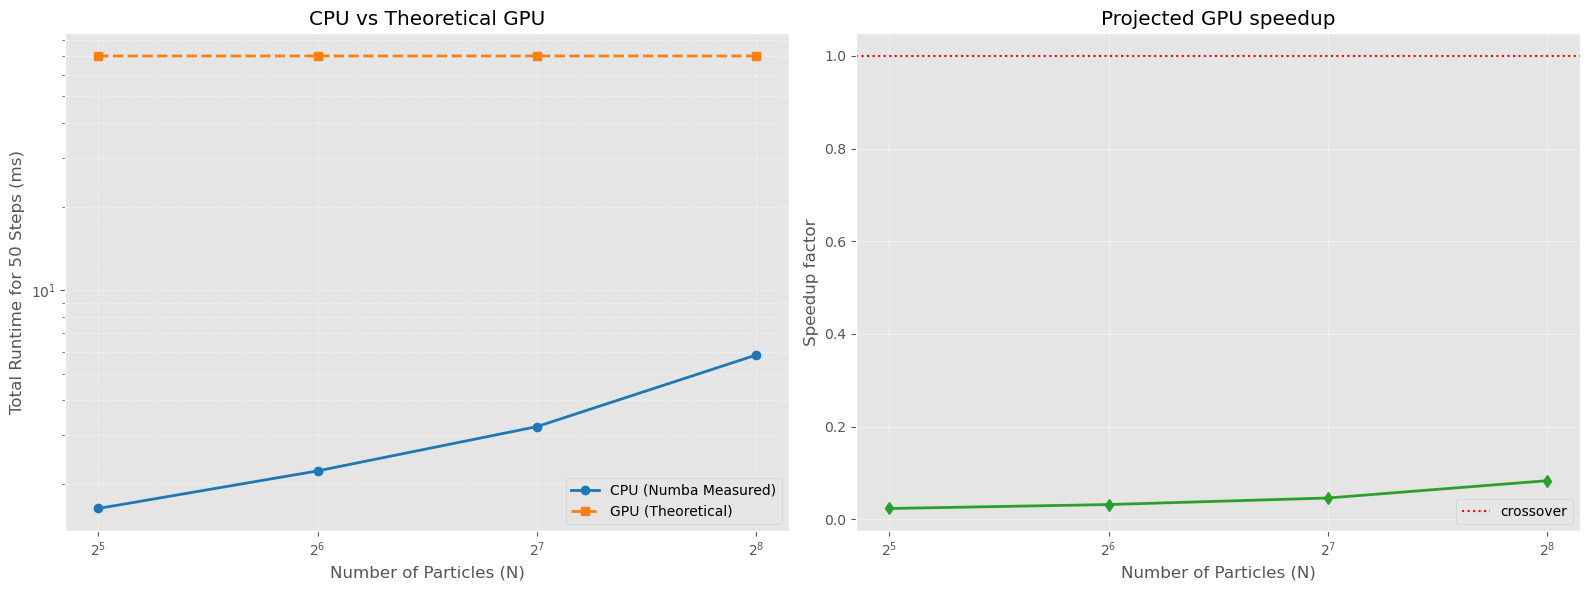

In [16]:
#Run the benchmark
up_to = 18
benchmark(Simulator, max_pow=up_to)